In [1]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import maelstrom as ms

In [14]:
import numpy as np
from lightkurve import search_lightcurvefile

def get_lightcurve(target, **kwargs):
    lc_collection = search_lightcurvefile(target, **kwargs).download_all()

    lc = lc_collection[0].PDCSAP_FLUX.normalize()
    for l in lc_collection[1:]:
        lc = lc.append(l.PDCSAP_FLUX.normalize())

    lc = lc.remove_nans()
    return lc

lc = get_lightcurve('KIC 4253860', cadence='long')

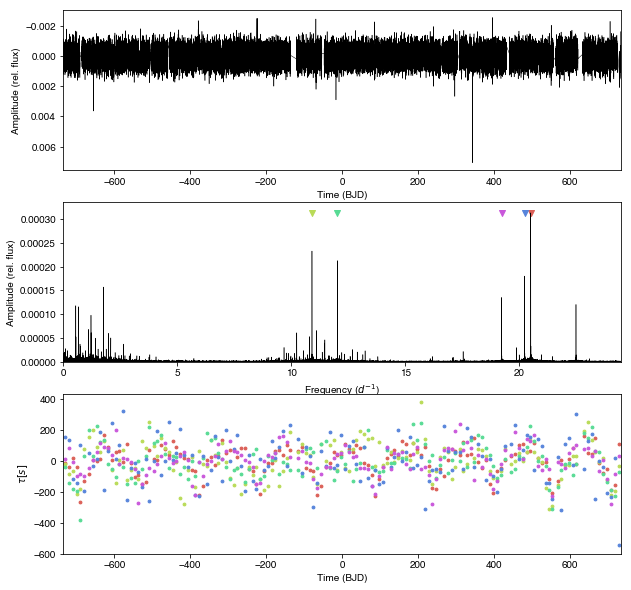

In [16]:
import maelstrom
ms = maelstrom.Maelstrom(lc.time, lc.flux, fmin =10, fmax=25., max_peaks=5)
#ms.setup_orbit_model(period=155.0611116)
ms.first_look(segment_size=10.)

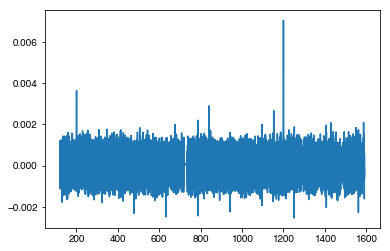

In [63]:
plt.plot(time, flux)

In [64]:
def dft_phase(x, y, freq):
    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
    return phase

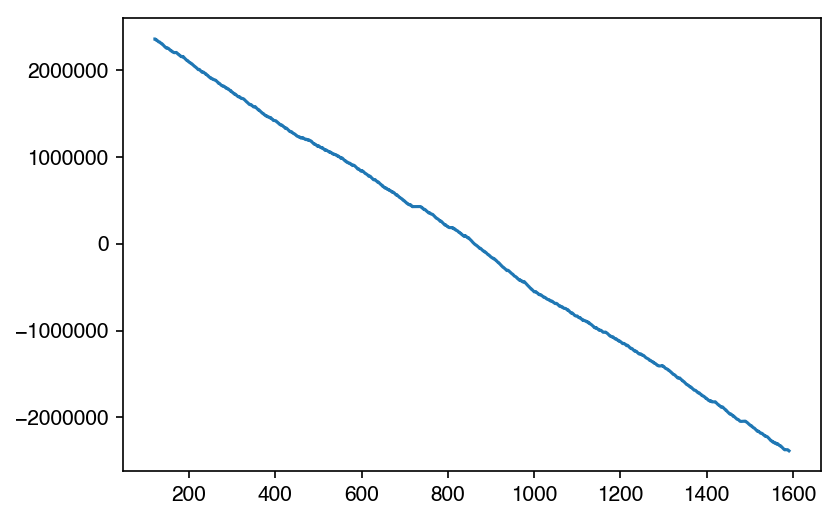

In [127]:
from astropy.stats import LombScargle

time, flux = lc.time, lc.flux - np.mean(lc.flux)
freq = ms.freq
segment_size=0.5

uHz_conv = 1e-6 * 24 * 60 * 60
time_0 = time[0]
time_slice, mag_slice, phase = [], [], []
time_delays, time_midpoints = [], []

# Iterate over lightcurve
for t, y in zip(time, flux):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        phase.append(dft_phase(time_slice, mag_slice, freq))
        time_0 = t
        time_slice, mag_slice = [], []

phase = np.array(phase).T
# Phase wrapping patch
for ph, f in zip(phase, freq):
    #mean_phase = np.mean(ph)
    #ph[np.where(ph - mean_phase > np.pi/2)] -= np.pi
    #ph[np.where(ph - mean_phase < -np.pi/2)] += np.pi
    #ph -= np.mean(ph)
    ph = np.unwrap(ph)
    ph -= np.mean(ph)

    td = ph / (2*np.pi*(f / uHz_conv * 1e-6))
    time_delays.append(td)
   

weights = [] 
for f in freq:
    model = LombScargle(time, flux)
    sc = model.power(f, method="fast", normalization="psd")

    fct = np.sqrt(4./len(time))
    weights.append(np.sqrt(sc) * fct)
weights /= np.max(weights) 


plt.plot(time_midpoints,np.average(time_delays,axis=0, weights=weights))

td_time, td_td = time_midpoints,np.average(time_delays,axis=0, weights=weights)


In [82]:

import theano.tensor as tt
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import exoplanet as xo
import astropy.units as u

with pm.Model() as model:
    # Parameters
    #period = pm.Normal("period", mu=1000., sd=.)
    period = pm.Normal("period", mu=155.0611116, sd=1)
    tref = pm.Uniform("tref", lower=-5000, upper=5000)
    varpi = pm.Uniform("varpi", lower=0, upper=50)
    eccen = pm.Uniform("eccen", lower=1e-3, upper=0.999, testval=0.62)
    logs = pm.Normal('logs', mu=np.log(np.std(flux)), sd=10)
    #jitter = pm.Uniform('jitter', lower=0, upper=10)
    lighttime = pm.Uniform('lighttime', lower=-200, upper=20.)
    drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=1.)
    # Deterministic transformations
    # Mean anom
    M = 2.0 * np.pi * (td_time - tref) / period
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * tt.cos(f)
    psi = -factor * tt.sin(f + varpi)
    
    tau = pm.Deterministic('tau', lighttime * psi)
    tau += drift_gradient * td_time
    taumodel = pm.Deterministic('taumodel', tau - tt.mean(tau))
    
    # Condition on the observations
    pm.Normal("obs_photometry", mu=taumodel, sd=tt.exp(logs), observed=td_td)



/Users/danielhey/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -498.55, ||grad|| = 2.1656: 100%|██████████| 250/250 [00:00<00:00, 1376.83it/s] 


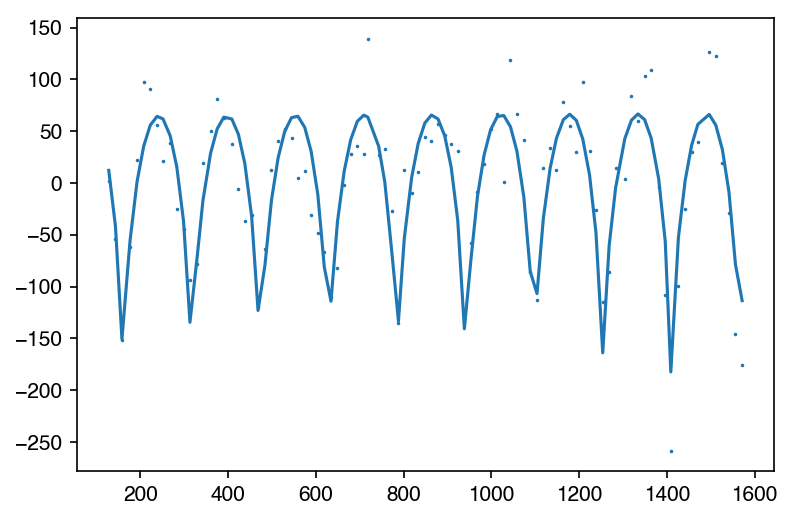

In [85]:
with model:
    map_params = pm.find_MAP()
    
plt.plot(td_time, map_params['taumodel'])
plt.scatter(td_time, td_td, 0.5)

In [86]:
with model:
    trace = pm.sample(draws=2000, tune=2000, start=map_params, chains=2)

Sampling 2 chains: 100%|██████████| 8000/8000 [01:16<00:00, 104.81draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [87]:
pm.summary(trace, varnames=["period", "lighttime", "tref", "varpi", "eccen", "drift_grad"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,156.331018,0.367064,0.010943,155.684749,157.115645,947.111393,1.000069
lighttime,-123.736718,18.387382,1.074926,-163.908778,-92.908180,145.144894,0.999947
tref,4536.236748,8.374436,0.242515,4520.127225,4552.446793,954.041656,1.000408
varpi,29.677696,0.312581,0.015299,28.983952,30.265813,246.356903,1.002222
eccen,0.906388,0.084819,0.002915,0.739361,0.998973,621.986655,0.999853
drift_grad,0.000662,0.009425,0.000257,-0.017170,0.019741,1306.001984,1.000643


Text(0, 0.5, 'Time delay (s)')

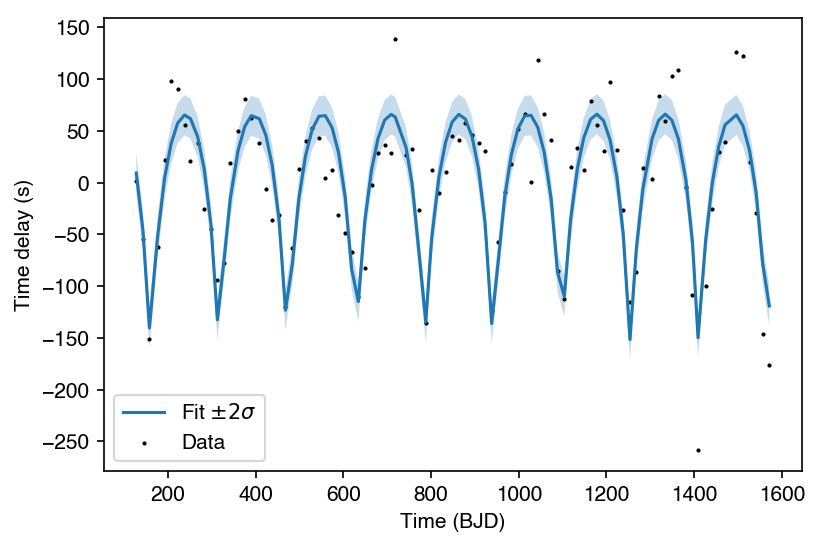

In [88]:
med = np.median(trace['taumodel'], axis=0)#[0]
sd = np.std(trace['taumodel'], axis=0)[0]
plt.plot(td_time, med, label=r'Fit $\pm 2\sigma$')
plt.fill_between(td_time, med+2*sd, med-2*sd, alpha=0.25)
plt.scatter(td_time, td_td,1, c='black', label='Data')

plt.legend()
plt.xlabel('Time (BJD)')
plt.ylabel('Time delay (s)')

In [94]:
t, y = lc.time, lc.flux - np.mean(lc.flux)
t0_guess = t[np.argmin(y)]
t_transit, y_transit = t, y

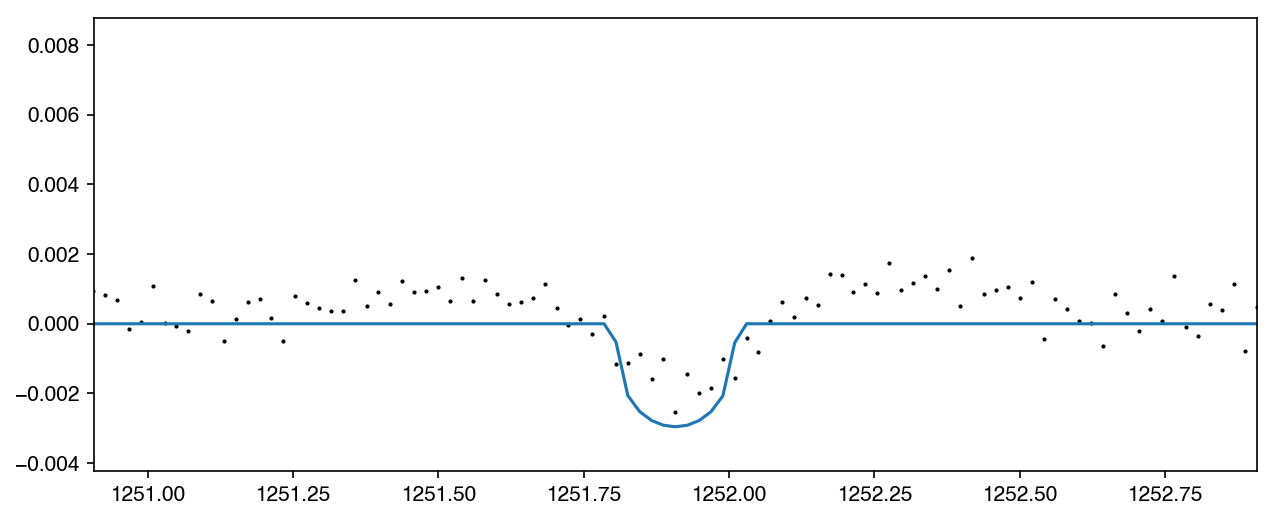

In [104]:


from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import exoplanet as xo
import astropy.units as u

with pm.Model() as model:
    # It's much faster to sample from a log-space period
    logP = pm.Normal("logP", mu=np.log(155.0611116), sd=10., shape=1)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # Time delay drift
    drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=1.)
    
    # The time of conjunction
    tc = pm.Normal("tc", mu=t0_guess, sd=1.0, shape=1, testval=t0_guess)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(y)), sd=10)
    
    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.01, max_radius=1.,
        testval_r=0.05,
        testval_b=0.5
    )
    
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=2.27)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=1e-3, upper=0.999, testval=0.58)
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.)
    # Quadratic limb darkening
    u_star = xo.distributions.QuadLimbDark("u_star",)
    
    # Orbit model
    # Note if m_star and r_star are NOT supplied, r measures the radius ratio instead of r_secondary
    orbit = xo.orbits.KeplerianOrbit(
        period=period, 
        t0=tc,
        ecc=eccen,
        omega=omega,
        b=b
    )
    
    
    
    # Compute the model light curve
    light_curves = xo.StarryLightCurve(u_star).get_light_curve(
        orbit=orbit, r=0.05, t=t_transit, texp=29.4/1440.)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Save light curve in chain
    pm.Deterministic('lc', light_curve)
    pm.Normal("obs", mu=light_curve, sd=tt.exp(logs_td), observed=y_transit)
    
fig, axes = plt.subplots(1,1, figsize=[10,4])
with model:
    ax = axes
    ax.scatter(t_transit, y_transit, 1, c='black')
    ax.plot(t_transit, xo.eval_in_model(light_curve))
    ax.set_xlim(t0_guess-1, t0_guess+1)




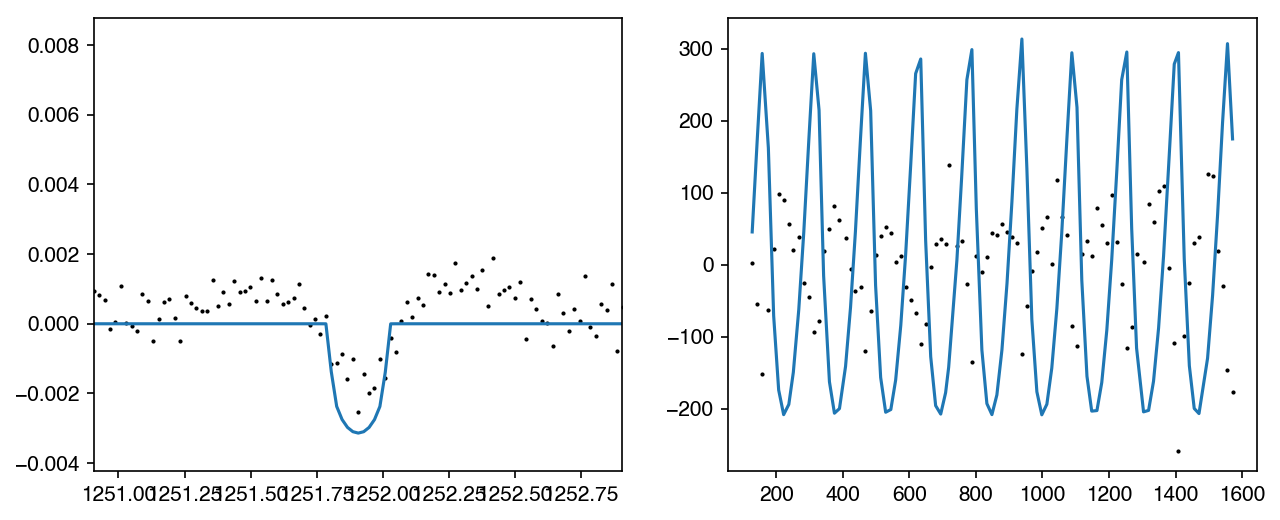

In [116]:


from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import exoplanet as xo
import astropy.units as u

with pm.Model() as model:
    # It's much faster to sample from a log-space period
    #logP = pm.Normal("logP", mu=np.log(155.0611116), sd=10., shape=1)
    #period = pm.Deterministic("period", pm.math.exp(logP))
    period = 155.0611116
    # Time delay drift
    drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=1.)
    
    # The time of conjunction
    tc = pm.Normal("tc", mu=t0_guess, sd=1.0, shape=1, testval=t0_guess)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(y)), sd=10, testval=0.)
    logs_td = pm.Normal('logs_td', mu=np.log(np.std(y)), sd=10, testval=0.)
    
    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.01, max_radius=0.4,
        testval_r=0.05,
        testval_b=0.33
    )
    
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=2.27)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=1e-3, upper=0.999, testval=0.58)
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.)
    # Quadratic limb darkening
    u_star = xo.distributions.QuadLimbDark("u_star",)
    
    # Orbit model
    # Note if m_star and r_star are NOT supplied, r measures the radius ratio instead of r_secondary
    orbit = xo.orbits.KeplerianOrbit(
        period=period, 
        t0=tc,
        ecc=eccen,
        omega=omega,
        b=b
    )
    
    # Mean anom
    M = 2.0 * np.pi * (td_time - orbit.tref) / period
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * tt.cos(f)
    psi = factor * tt.sin(f + omega)
    
    lighttime = pm.Deterministic('lighttime', orbit.a * tt.sin(orbit.incl) * 6.957e8 / 299792458)
    tau = lighttime * psi
    #tau += drift_gradient * td_time
    
    taumodel = pm.Deterministic('taumodel', tau - tt.mean(tau))
    
    # Compute the model light curve
    light_curves = xo.StarryLightCurve(u_star).get_light_curve(
        orbit=orbit, r=r, t=t_transit, texp=29.4/1440.)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Save light curve in chain
    pm.Deterministic('lc', light_curve)
    
    # The likelihood functions assuming known Gaussian uncertainty
    pm.Normal("td", mu=taumodel, sd=tt.exp(logs_lc), observed=td_td)
    pm.Normal("obs", mu=light_curve, sd=tt.exp(logs_td), observed=y_transit)
    
fig, axes = plt.subplots(1,2, figsize=[10,4])
with model:
    ax = axes[0]
    ax.scatter(t_transit, y_transit, 1, c='black')
    ax.plot(t_transit, xo.eval_in_model(light_curve))
    ax.set_xlim(t0_guess-1, t0_guess+1)
    
    
    ax = axes[1]
    ax.scatter(td_time, td_td, 1, c='black')
    ax.plot(td_time, xo.eval_in_model(taumodel))



/Users/danielhey/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 4.05e+05, ||grad|| = 1.765e+05: 100%|██████████| 50/50 [00:00<00:00, 187.21it/s]  


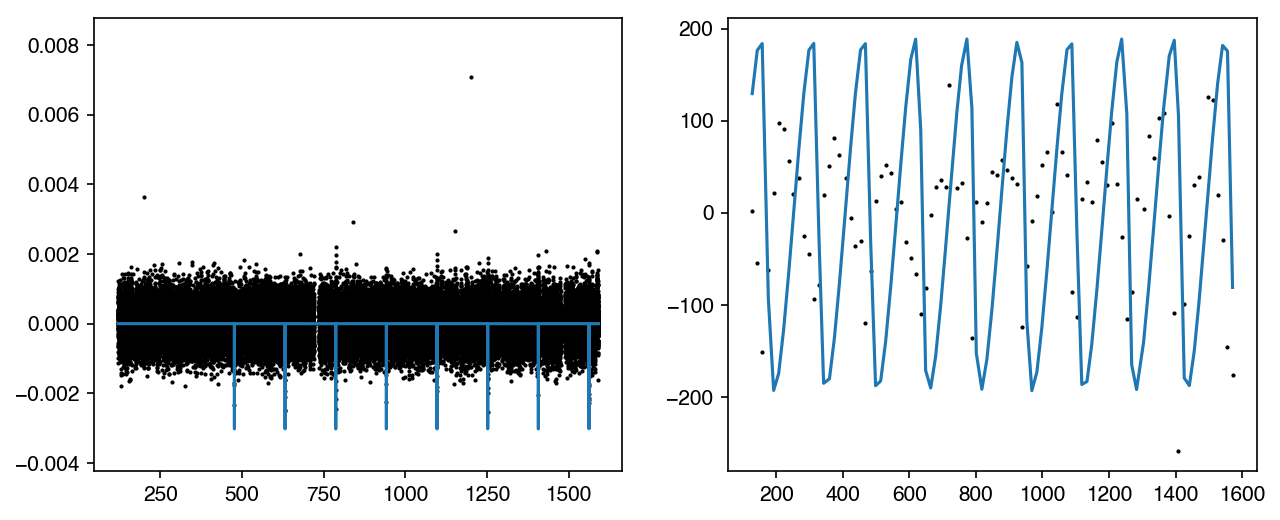

In [117]:
with model:
    map_params= pm.find_MAP()
    #map_params = xo.optimize()
    
fig, axes = plt.subplots(1,2, figsize=[10,4])
with model:
    ax = axes[0]
    ax.scatter(t_transit, y_transit, 1, c='black')
    ax.plot(t_transit, xo.eval_in_model(light_curve,map_params))
    #ax.set_xlim(t0_guess-1, t0_guess+1)
    
    
    ax = axes[1]
    ax.scatter(td_time, td_td, 1, c='black')
    ax.plot(td_time, xo.eval_in_model(taumodel,map_params))

In [118]:


np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=4000, start=map_params, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=4000)

/Users/danielhey/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 2 chains:  29%|██▊       | 231/804 [02:08<07:03,  1.35draws/s]


ValueError: Not enough samples to build a trace.

In [23]:
opt = ms.optimize()
model = ms.pin_orbit_model(opt)

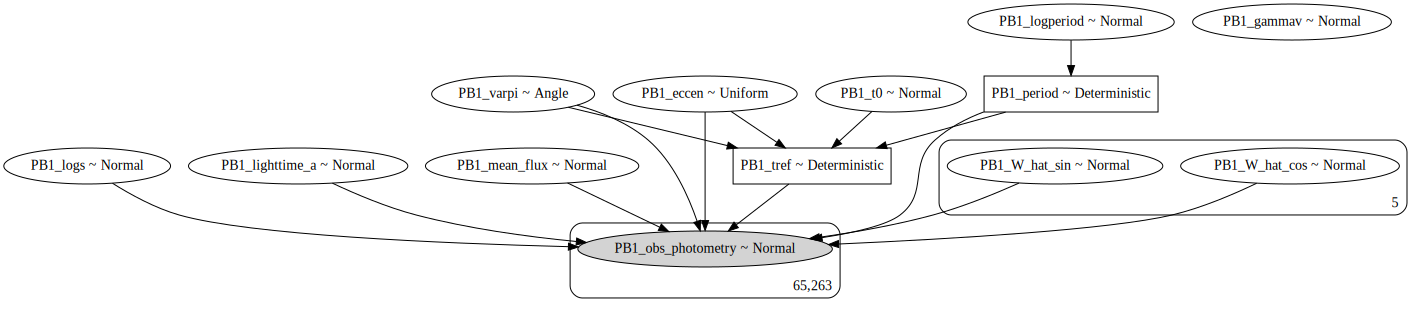

In [9]:
model.print_model()

In [25]:
opt = model.optimize()

optimizing logp for variables: ['PB1_W_hat_sin', 'PB1_W_hat_cos', 'PB1_mean_flux']
message: Desired error not necessarily achieved due to precision loss.
logp: 431234.3603156296 -> 431234.427620639
optimizing logp for variables: ['PB1_W_hat_sin', 'PB1_W_hat_cos', 'PB1_mean_flux', 'PB1_logs']
message: Desired error not necessarily achieved due to precision loss.
logp: 431234.427620639 -> 431234.63185691513
optimizing logp for variables: ['PB1_t0', 'PB1_lighttime_a']
message: Optimization terminated successfully.
logp: 431234.63185691513 -> 431238.0237552128
optimizing logp for variables: ['PB1_W_hat_sin', 'PB1_W_hat_cos', 'PB1_mean_flux', 'PB1_logs']
message: Desired error not necessarily achieved due to precision loss.
logp: 431238.0237552128 -> 431238.09548247827
optimizing logp for variables: ['PB1_t0', 'PB1_logperiod']
message: Desired error not necessarily achieved due to precision loss.
logp: 431238.09548247827 -> 431240.29405658855
optimizing logp for variables: ['PB1_varpi_angle

In [28]:
trace = model.sample(start=opt)

Sampling 2 chains:  20%|██        | 21/104 [01:08<07:29,  5.41s/draws]


ValueError: Not enough samples to build a trace.